<img src="https://github.com/Unidata/MetPy/raw/main/docs/_static/metpy_150x150.png" width=150 alt="MetPy logo"></img>
<img src="https://github.com/Unidata/MetPy/raw/main/docs/_static/unidata_150x150.png" width=150 alt="Unidata logo"></img>

# Plots

---

## Overview
`metpy.plots` contains a variety of tools to either enable creation of unique meteorological plots otherwise difficult or time-consuming to re-create in Python,
 - SkewTs
 - Hodographs
 - Surface and upper-air observation station model plots

or tools to make day-to-day scientific exploration easier, more convenient, or more accessible to those with a variety of backgrounds in meteorology and computing. This is primarily enabled through our *Declarative* plotting interface.

---

## Imports

In [1]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import pandas as pd

# get_test_data is primarily for internal testing and documentation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from metpy.cbook import get_test_data
from metpy.io import parse_metar_file
from metpy.plots import current_weather, sky_cover, Hodograph, SkewT, StationPlot, PlotGeometry, PlotObs, MapPanel, PanelContainer
from metpy.units import units

## [SkewT](https://unidata.github.io/MetPy/latest/examples/plots/Hodograph_Inset.html#sphx-glr-examples-plots-hodograph-inset-py)
*with an inset Hodograph!*

In [2]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('may4_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [3]:
hght = df['height'].values * units.hPa
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

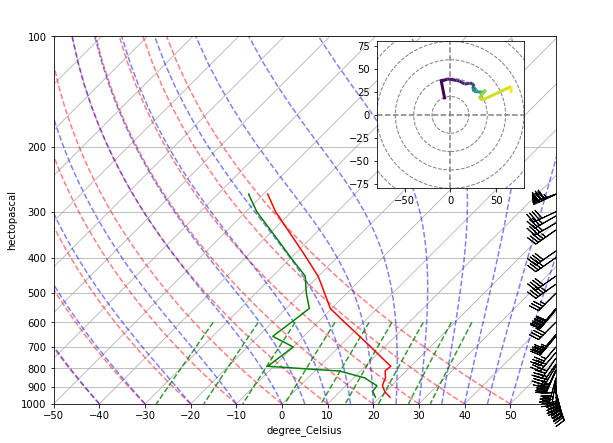

In [4]:
fig = plt.figure(figsize=(9, 9))

skew = SkewT(fig, rotation=45)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

skew.ax.set_xlim(-50, 60)

ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, hght)

## [Station Plots](https://unidata.github.io/MetPy/latest/examples/plots/Station_Plot.html#sphx-glr-examples-plots-station-plot-py)

For plotting Meteorological station models for surface or upper-air observations.

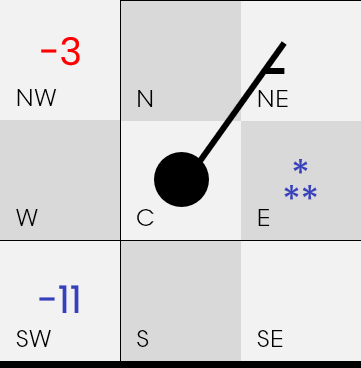

In [5]:
data = parse_metar_file(get_test_data('metar_20190701_1200.txt', as_file_obj=False))

data = data.dropna(how='any', subset=['wind_direction', 'wind_speed'])

In [6]:
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

point_locs = proj.transform_points(ccrs.PlateCarree(), data['longitude'].values,
                                   data['latitude'].values)

data = data[mpcalc.reduce_point_density(point_locs, 300000.)]

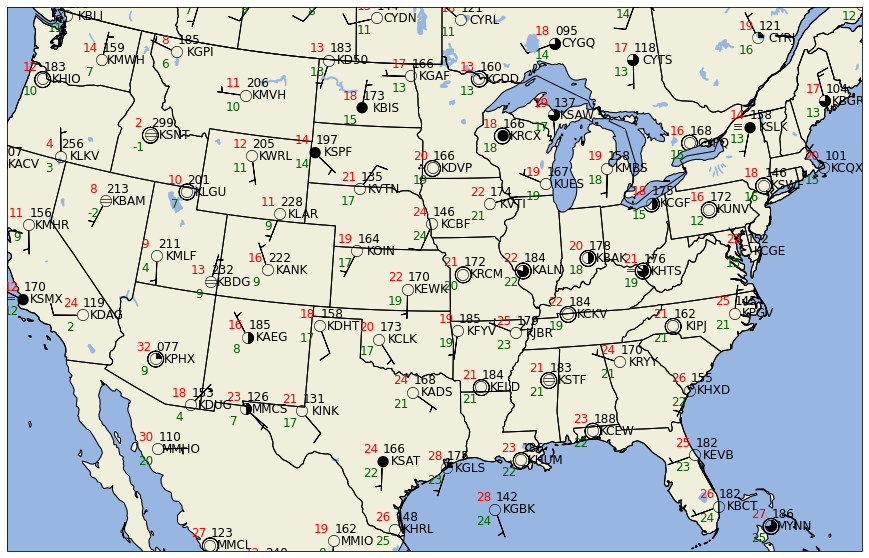

In [7]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

ax.set_extent((-118, -73, 23, 50))


# Start the station plot by specifying the axes to draw on, as well as the
# lon/lat of the stations (with transform). We also the fontsize to 12 pt.
stationplot = StationPlot(ax, data['longitude'].values, data['latitude'].values,
                          clip_on=True, transform=ccrs.PlateCarree(), fontsize=12)

# Plot the temperature and dew point to the upper and lower left, respectively, of
# the center point. Each one uses a different color.
stationplot.plot_parameter('NW', data['air_temperature'].values, color='red')
stationplot.plot_parameter('SW', data['dew_point_temperature'].values,
                           color='darkgreen')

# A more complex example uses a custom formatter to control how the sea-level pressure
# values are plotted. This uses the standard trailing 3-digits of the pressure value
# in tenths of millibars.
stationplot.plot_parameter('NE', data['air_pressure_at_sea_level'].values,
                           formatter=lambda v: format(10 * v, '.0f')[-3:])

# Plot the cloud cover symbols in the center location.
stationplot.plot_symbol('C', data['cloud_coverage'].values, sky_cover)

# Same this time, but plot current weather to the left of center.
stationplot.plot_symbol('W', data['current_wx1_symbol'].values, current_weather)

# Add wind barbs
stationplot.plot_barb(data['eastward_wind'].values, data['northward_wind'].values)

# Also plot the actual text of the station id. Instead of cardinal directions,
# plot further out by specifying a location of 2 increments in x and 0 in y.
stationplot.plot_text((2, 0), data['station_id'].values)

plt.show()

## Declarative Plotting

### [Surface station plots](https://unidata.github.io/MetPy/latest/examples/plots/surface_declarative.html#sphx-glr-examples-plots-surface-declarative-py), again?

In [8]:
from datetime import datetime, timedelta

data = pd.read_csv(get_test_data('SFC_obs.csv', as_file_obj=False),
                   infer_datetime_format=True, parse_dates=['valid'])

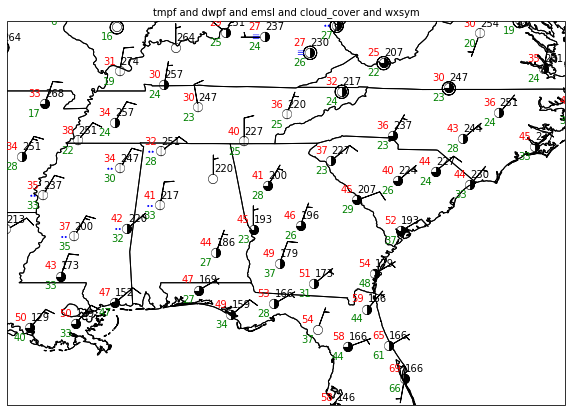

In [9]:
# Plotting the Observations using a 15 minute time window for surface observations
obs = PlotObs()
obs.data = data
obs.time = datetime(1993, 3, 12, 13)
obs.time_window = timedelta(minutes=15)
obs.level = None
obs.fields = ['tmpf', 'dwpf', 'emsl', 'cloud_cover', 'wxsym']
obs.locations = ['NW', 'SW', 'NE', 'C', 'W']
obs.colors = ['red', 'green', 'black', 'black', 'blue']
obs.formats = [None, None, lambda v: format(10 * v, '.0f')[-3:], 'sky_cover',
               'current_weather']
obs.vector_field = ('uwind', 'vwind')
obs.reduce_points = 1

# Add map features for the particular panel
panel = MapPanel()
panel.layout = (1, 1, 1)
panel.area = 'ga'
panel.projection = ccrs.PlateCarree()
panel.layers = ['coastline', 'borders', 'states']
panel.plots = [obs]

# Collecting panels for complete figure
pc = PanelContainer()
pc.size = (10, 10)
pc.panels = [panel]

# Showing the results
pc.show()

### [PlotGeometry](https://unidata.github.io/MetPy/latest/examples/plots/spc_convective_outlook.html#sphx-glr-examples-plots-spc-convective-outlook-py)

In [10]:
day1_outlook = gpd.read_file(get_test_data('spc_day1otlk_20210317_1200_lyr.geojson'))
day1_outlook

,DN,VALID,EXPIRE,ISSUE,LABEL,LABEL2,stroke,fill,geometry
0,2,202103171200,202103181200,202103170552,TSTM,General Thunderstorms Risk,#55BB55,#C1E9C1,"MULTIPOLYGON (((-75.21498 35.85713, -75.12000 ..."
1,3,202103171200,202103181200,202103170552,MRGL,Marginal Risk,#005500,#66A366,"MULTIPOLYGON (((-85.71646 29.55317, -85.76700 ..."
2,4,202103171200,202103181200,202103170552,SLGT,Slight Risk,#DDAA00,#FFE066,"MULTIPOLYGON (((-85.95065 29.84763, -85.98500 ..."
3,5,202103171200,202103181200,202103170552,ENH,Enhanced Risk,#FF6600,#FFA366,"MULTIPOLYGON (((-88.40000 30.20000, -90.09000 ..."
4,6,202103171200,202103181200,202103170552,MDT,Moderate Risk,#CC0000,#E06666,"MULTIPOLYGON (((-87.07000 31.68000, -88.65000 ..."
5,8,202103171200,202103181200,202103170552,HIGH,High Risk,#CC00CC,#EE99EE,"MULTIPOLYGON (((-91.88000 32.99000, -89.82000 ..."


/home/dcamron/mambaforge/envs/pythia-metpy-tutorial/lib/python3.10/site-packages/metpy/plots/declarative.py:2061: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  geo_obj = max(geo_obj, key=lambda x: x.length)


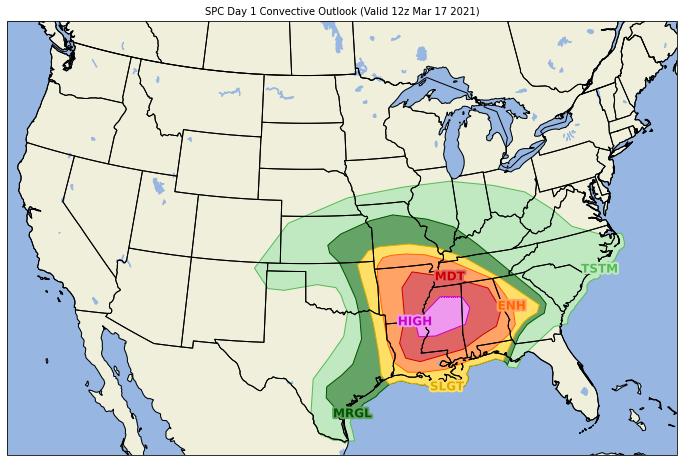

In [11]:
geo = PlotGeometry()
geo.geometry = day1_outlook['geometry']
geo.fill = day1_outlook['fill']
geo.stroke = day1_outlook['stroke']
geo.labels = day1_outlook['LABEL']
geo.label_fontsize = 'large'

panel = MapPanel()
panel.title = 'SPC Day 1 Convective Outlook (Valid 12z Mar 17 2021)'
panel.plots = [geo]
panel.area = [-120, -75, 25, 50]
panel.projection = 'lcc'
panel.layers = ['lakes', 'land', 'ocean', 'states', 'coastline', 'borders']

pc = PanelContainer()
pc.size = (12, 8)
pc.panels = [panel]
pc.show()